<a href="https://colab.research.google.com/github/anirudhkumar29/db-A-Discontinuity-bounded-Search-for-Kinodynamic-Mobile-Robot-Motion-Planning/blob/main/Lab4_rmp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found a path with 11 nodes.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


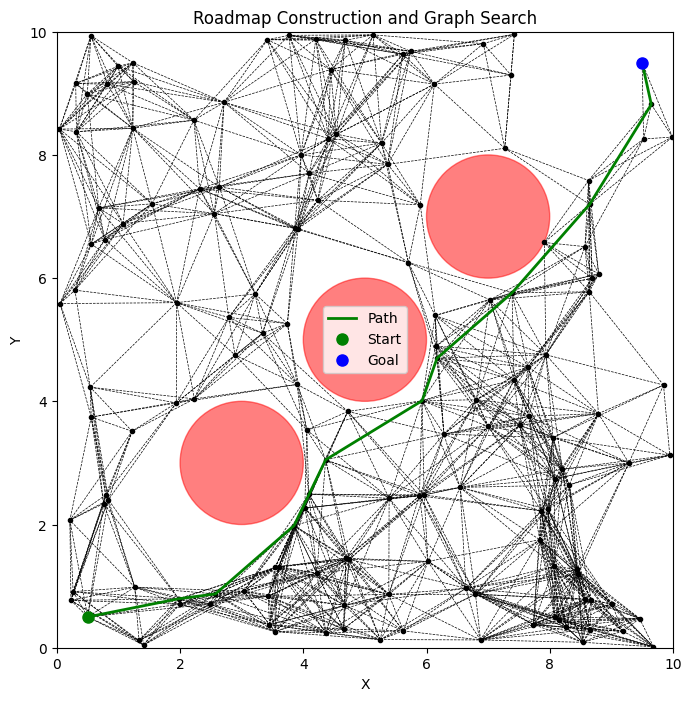

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx




# Collision Checking Functions

def point_in_circle(point, circle):
    """
    Check if a point is inside a circular obstacle.
    circle: dict with keys 'center' (tuple) and 'radius'
    """
    return np.linalg.norm(np.array(point) - np.array(circle['center'])) <= circle['radius']

def line_intersects_circle(p1, p2, circle):
    """
    Check if the line segment from p1 to p2 intersects a circle.
    p1, p2: Points as (x, y).
    circle: dictionary with keys 'center' and 'radius'.
    Returns True if the segment collides with the circle.
    """
    center = np.array(circle['center'])
    p1 = np.array(p1)
    p2 = np.array(p2)
    d = p2 - p1
    f = p1 - center

    a = np.dot(d, d)
    b = 2 * np.dot(f, d)
    c = np.dot(f, f) - circle['radius']**2

    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        # No intersection if discriminant is negative.
        return False

    discriminant = np.sqrt(discriminant)
    t1 = (-b - discriminant) / (2 * a)
    t2 = (-b + discriminant) / (2 * a)

    # Check if either intersection falls within the segment [0,1]
    if (0 <= t1 <= 1) or (0 <= t2 <= 1):
        return True
    return False

def is_collision_free(p1, p2, obstacles):
    """
    Check that the path (straight-line) from p1 to p2 does not collide with any obstacle.
    """
    for obs in obstacles:
        if line_intersects_circle(p1, p2, obs):
            return False
    return True

def is_point_free(p, obstacles):
    """
    Check whether a point is collision free (not inside any obstacle).
    """
    for obs in obstacles:
        if point_in_circle(p, obs):
            return False
    return True




# Roadmap Construction (Probabilistic Roadmap - PRM)

def construct_roadmap(num_samples, workspace, obstacles, connection_radius):
    """
    Sample free nodes and construct a roadmap.

    Parameters:
      num_samples: Number of random free nodes.
      workspace: dict with keys 'xmin', 'xmax', 'ymin', 'ymax'.
      obstacles: list of circular obstacles.
      connection_radius: maximum distance to connect nodes.

    Returns:
      nodes: list of free nodes [(x, y), ...]
      G: networkx Graph with nodes and weighted edges.
    """
    nodes = []
    xmin, xmax = workspace['xmin'], workspace['xmax']
    ymin, ymax = workspace['ymin'], workspace['ymax']

    # Sample nodes until we have enough free ones.
    while len(nodes) < num_samples:
        p = (np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax))
        if is_point_free(p, obstacles):
            nodes.append(p)

    # Create graph and add nodes.
    G = nx.Graph()
    for i, p in enumerate(nodes):
        G.add_node(i, pos=p)

    # Attempt to connect each pair of nodes that are close enough.
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j])) <= connection_radius:
                # Check if the direct path is collision-free.
                if is_collision_free(nodes[i], nodes[j], obstacles):
                    weight = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                    G.add_edge(i, j, weight=weight)
    return nodes, G




# Insert Start and Goal into the Roadmap

def add_start_goal(G, nodes, start, goal, obstacles, connection_radius):
    """
    Insert start and goal nodes into the graph by connecting them to nearby nodes.
    """
    # Append start and goal to nodes list
    start_idx = len(nodes)
    nodes.append(start)
    goal_idx = len(nodes)
    nodes.append(goal)

    G.add_node(start_idx, pos=start)
    G.add_node(goal_idx, pos=goal)

    # For each new node, connect to existing nodes if feasible
    for idx in [start_idx, goal_idx]:
        for i, p in enumerate(nodes[:-2]):
            if np.linalg.norm(np.array(nodes[idx]) - np.array(p)) <= connection_radius:
                if is_collision_free(nodes[idx], p, obstacles):
                    weight = np.linalg.norm(np.array(nodes[idx]) - np.array(p))
                    G.add_edge(idx, i, weight=weight)
    return start_idx, goal_idx




# Graph Search for the Roadmap

def search_roadmap(G, start_idx, goal_idx):
    """
    Use Dijkstra's algorithm to compute the shortest path from start to goal in G.
    """
    try:
        path = nx.shortest_path(G, source=start_idx, target=goal_idx, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return None



# Visualization of Roadmap and Path

def visualize_roadmap(nodes, G, path, obstacles, workspace):
    plt.figure(figsize=(8, 8))
    # Plot obstacles
    for obs in obstacles:
        circle = plt.Circle(obs['center'], obs['radius'], color='red', fill=True, alpha=0.5)
        plt.gca().add_patch(circle)

    # Plot graph edges
    for (i, j) in G.edges():
        p1 = nodes[i]
        p2 = nodes[j]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', linewidth=0.5)

    # Plot nodes
    ns = np.array(nodes)
    plt.plot(ns[:,0], ns[:,1], 'ko', markersize=3)

    # Plot the solution path, if found.
    if path is not None:
        path_coords = [nodes[i] for i in path]
        xs, ys = zip(*path_coords)
        plt.plot(xs, ys, 'g-', linewidth=2, label='Path')

    # Plot start and goal
    start = nodes[path[0]] if path is not None else nodes[-2]
    goal = nodes[path[-1]] if path is not None else nodes[-1]
    plt.plot(start[0], start[1], 'go', markersize=8, label='Start')
    plt.plot(goal[0], goal[1], 'bo', markersize=8, label='Goal')

    plt.xlim(workspace['xmin'], workspace['xmax'])
    plt.ylim(workspace['ymin'], workspace['ymax'])
    plt.title('Roadmap Construction and Graph Search')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



# Main Function: Roadmap Construction and Graph Search

def roadmap_planning():
    # Define workspace dimensions.
    workspace = {'xmin': 0, 'xmax': 10, 'ymin': 0, 'ymax': 10}

    # Define circular obstacles.
    obstacles = [
        {'center': (3, 3), 'radius': 1.0},
        {'center': (7, 7), 'radius': 1.0},
        {'center': (5, 5), 'radius': 1.0}
    ]

    # Parameters for the roadmap.
    num_samples = 150          # Number of sample nodes
    connection_radius = 2.0    # Maximum distance to connect two nodes

    # Construct the roadmap.
    nodes, G = construct_roadmap(num_samples, workspace, obstacles, connection_radius)

    # Define start and goal positions.
    start = (0.5, 0.5)
    goal = (9.5, 9.5)

    # Add start and goal to the graph.
    start_idx, goal_idx = add_start_goal(G, nodes, start, goal, obstacles, connection_radius)

    # Search the roadmap to find a path.
    path = search_roadmap(G, start_idx, goal_idx)
    if path is None:
        print("No path found between the start and goal.")
    else:
        print("Found a path with", len(path), "nodes.")

    # Visualize the roadmap and the path.
    visualize_roadmap(nodes, G, path, obstacles, workspace)

if __name__ == "__main__":
    roadmap_planning()
